In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

In [2]:
df = pd.read_csv("C:/Users/user/Downloads/PAMAP2.csv",index_col = None)

In [3]:
df = df.drop("Unnamed: 0",axis = 1)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [5]:
class ActivityDataset(Dataset):
    def __init__(self, X, y):
        # 데이터를 PyTorch 텐서로 변환 후 필요한 경우 차원 추가
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (batch_size, 1, length) 형태로 변경
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [15]:
# 모델 클래스 정의
class CNN_LSTM_Model(nn.Module):
    def __init__(self, num_features, num_classes):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=32, hidden_size=100, batch_first=True)
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        print(x.shape)
        x = x.permute(0, 2, 1)
        print(x.shape)
        x = self.conv1(x)
        print(x.shape)
        x = torch.relu(x)
        print(x.shape)
        x = self.conv2(x)
        print(x.shape)
        x = torch.relu(x)
        print(x.shape)
        x = self.dropout(x)
        print(x.shape)
        x = self.maxpool(x)
        print(x.shape)
        x = x.permute(0, 2, 1)
        print(x.shape)
        x, _ = self.lstm(x)
        print(x.shape)
        x = x[:, -1, :]
        print(x.shape)
        x = torch.relu(self.fc1(x))
        print(x.shape)
        x = self.fc2(x)
        print(x.shape)
        return x

    

In [16]:
# 데이터 로드 및 전처리
X = df.drop(columns=['activityID', 'timestamp', 'subject_id']).values
y = df['activityID'].values - 1  # 클래스 라벨을 0부터 시작하도록 변경


In [30]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6, 11, 12, 15, 16, 23], dtype=int64)

In [28]:
conversion_map = dict(zip(np.unique(y), range(len(np.unique(y)))))

In [31]:
conversion_map 

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 11: 7, 12: 8, 15: 9, 16: 10, 23: 11}

In [34]:
new_y = np.array([conversion_map[value] for value in np.unique(y)])

In [36]:
np.unique(new_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [17]:
# 데이터 표준화
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
# 데이터셋 분할 및 DataLoader 생성
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = ActivityDataset(X_train, y_train)
test_dataset = ActivityDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, pin_memory=True)

In [24]:
X_train.shape[1]

40

In [37]:
# 모델, 옵티마이저, 손실 함수 인스턴스화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_Model(num_features=X_train.shape[1], num_classes=len(np.unique(new_y)))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [38]:
# 모델 학습 함수 정의
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    train_loss /= len(train_loader)
    accuracy = 100. * correct / total
    return train_loss, accuracy

In [39]:
# 모델 테스트 함수 정의
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return test_loss, accuracy


In [40]:
# 학습 및 테스트 루프
epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_accuracy = train_model(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy = test_model(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}')

torch.Size([64, 1, 40])
torch.Size([64, 40, 1])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 5])
torch.Size([64, 64, 5])
torch.Size([64, 64, 5])
torch.Size([64, 64, 2])
torch.Size([64, 2, 64])


RuntimeError: shape '[25600, 1]' is invalid for input of size 12800

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

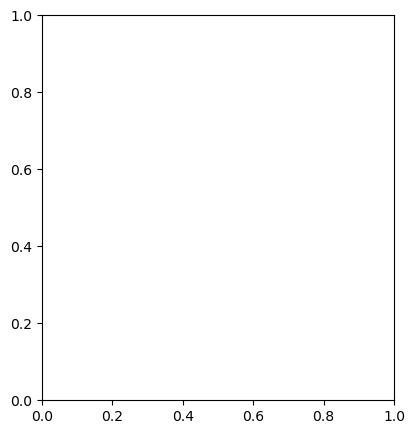

In [23]:
# 결과 시각화
import matplotlib.pyplot as plt

# 손실 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
